# Transformer 실습

이번 실습에서는 감정 분석 task에 RNN 대신 Transformer를 구현하여 적용해 볼 것입니다.
Library import나 dataloader 생성은 RNN 실습 때와 똑같기 때문에 설명은 넘어가도록 하겠습니다.

### LongTensor
torch.LongTensor를 사용하는 이유는 다음과 같습니다

토큰 ID의 데이터 타입: 토큰 ID는 정수(양의 정수)이며, PyTorch에서 정수형 데이터를 표현하기 위해 LongTensor(64비트 정수) 또는 IntTensor(32비트 정수)가 필요합니다.

어휘 사전 크기 지원: LongTensor(int64)는 IntTensor(int32)보다 더 넓은 범위의 정수를 표현할 수 있어, 큰 어휘 사전을 가진 토크나이저에서도 문제없이 사용할 수 있습니다.

패딩 및 특수 토큰 지원: 패딩 토큰 ID와 같은 특수 토큰도 정수로 표현되며, 모델이 이를 올바르게 처리하려면 모든 입력이 동일한 타입(LongTensor)이어야 합니다.

간단히 말해, 텍스트를 숫자(토큰 ID)로 변환한 후 PyTorch가 이해할 수 있는 텐서 형식으로 바꿔주는 역할을 합니다.

In [2]:

import os
os.environ['KMP_DUPLICATE_LIB_OK']='TRUE'
os.environ['CUDA_LAUNCH_BLOCKING']='1'
os.environ['TORCH_USE_CUDA_DSA'] = '1'

import torch
from datasets import load_dataset
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
from transformers import BertTokenizerFast
from tokenizers import (
    decoders,
    models,
    normalizers,
    pre_tokenizers,
    processors,
    trainers,
    Tokenizer,
)


# ds = load_dataset("stanfordnlp/imdb")
train_ds = load_dataset("stanfordnlp/imdb", split="train[:5%]")
test_ds = load_dataset("stanfordnlp/imdb", split="test[:5%]")

tokenizer = torch.hub.load('huggingface/pytorch-transformers', 'tokenizer', 'bert-base-uncased')
max_len = 400

# def collate_fn(batch):
#   max_len = 400
#   texts, labels = [], []
#   for row in batch:
#     labels.append(row['label'])
#     texts.append(row['text'])

#   texts = torch.LongTensor(tokenizer(texts, padding=True, truncation=True, max_length=max_len).input_ids)
#   labels = torch.LongTensor(labels)

#   return texts, labels

import re

def clean_text(text):
    # HTML 태그 제거 (</br> 포함)
    text = re.sub(r'<.*?>', '', text)
    # * 문자 제거
    text = re.sub(r'\*', '', text)
    # 추가적으로 필요한 경우 여러 공백을 하나로 변환
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

def collate_fn(batch):
  texts, labels = [], []
  for row in batch:
    # 텍스트 클렌징 과정 추가
    cleaned_text = clean_text(row['text'])
    labels.append(tokenizer(cleaned_text, truncation=True, max_length=max_len).input_ids[-3])
    texts.append(torch.LongTensor(tokenizer(cleaned_text, truncation=True, max_length=max_len).input_ids[:-3]))

  texts = pad_sequence(texts, batch_first=True, padding_value=tokenizer.pad_token_id)
  labels = torch.LongTensor(labels)

  return texts, labels

train_loader = DataLoader(
    train_ds, batch_size=64, shuffle=True, collate_fn=collate_fn
)
test_loader = DataLoader(
    test_ds, batch_size=64, shuffle=False, collate_fn=collate_fn
)

Using cache found in C:\Users\junu/.cache\torch\hub\huggingface_pytorch-transformers_main


In [3]:
tokenizer.model_max_length

512

In [4]:
torch.cuda.empty_cache()

In [5]:
# train_loader에서 라벨 확인하기
print("실제 사용되는 라벨 값 확인")
labels_set = set()
count = 0

# 첫 몇 개 배치에서 라벨을 확인
for texts, labels in train_loader:
    batch_labels = labels.tolist()
    labels_set.update(batch_labels)
    
    # 일부 예시 출력
    if count < 3:
        print(f"배치 {count+1}의 라벨 예시: {batch_labels[:5]}")
    
    count += 1
    if count >= 5:  # 5개 배치만 확인
        break

print(f"고유한 라벨 값: {sorted(list(labels_set))}")
print(f"라벨의 종류 수: {len(labels_set)}")

# 원본 데이터셋의 라벨과 비교
original_labels = set([sample['label'] for sample in list(train_ds)[:100]])
print(f"원본 데이터셋의 라벨: {sorted(list(original_labels))}")

실제 사용되는 라벨 값 확인
배치 1의 라벨 예시: [7615, 2100, 2051, 4432, 2000]
배치 2의 라벨 예시: [1013, 2045, 1016, 7443, 11544]
배치 3의 라벨 예시: [2184, 2055, 21553, 2205, 29132]
고유한 라벨 값: [999, 1000, 1005, 1007, 1010, 1011, 1012, 1013, 1016, 1018, 1024, 1029, 1037, 1042, 1055, 1996, 1997, 1998, 1999, 2000, 2002, 2003, 2004, 2005, 2007, 2008, 2009, 2011, 2012, 2015, 2017, 2022, 2023, 2025, 2026, 2028, 2031, 2032, 2033, 2034, 2035, 2041, 2042, 2045, 2051, 2055, 2061, 2062, 2068, 2070, 2079, 2081, 2082, 2091, 2099, 2100, 2105, 2106, 2125, 2135, 2143, 2147, 2153, 2155, 2166, 2171, 2172, 2175, 2176, 2180, 2182, 2184, 2185, 2188, 2189, 2192, 2196, 2203, 2204, 2205, 2243, 2259, 2265, 2302, 2320, 2338, 2362, 2383, 2412, 2464, 2469, 2488, 2507, 2526, 2535, 2537, 2568, 2573, 2618, 2619, 2625, 2653, 2671, 2686, 2694, 2711, 2729, 2769, 2791, 2859, 2869, 2909, 2919, 2964, 2978, 2979, 2989, 3012, 3052, 3185, 3335, 3338, 3363, 3374, 3380, 3431, 3494, 3602, 3636, 3644, 3666, 3737, 3898, 4138, 4228, 4268, 4378, 4426, 4432, 4435,

## Self-attention

이번에는 self-attention을 구현해보겠습니다.
Self-attention은 shape이 (B, S, D)인 embedding이 들어왔을 때 attention을 적용하여 새로운 representation을 만들어내는 module입니다.
여기서 B는 batch size, S는 sequence length, D는 embedding 차원입니다.
구현은 다음과 같습니다.

B: 배치 크기 (Batch size)  
S: 시퀀스 길이 (Sequence length) - 토큰의 개수  
D: 임베딩 차원 (Embedding dimension)  
H: 어텐션 헤드의 수 (Number of attention heads)  
D': 헤드 당 차원 (Dimension per head), D = H × D'  
멀티 헤드 어텐션에서는 하나의 큰 어텐션 연산 대신, 여러 개의 작은 어텐션 연산을 병렬로 수행합니다. 이를 위해 Q, K, V 행렬을 여러 헤드로 분할해야 합니다.
원래 Q, K, V의 형태가 (B, S, D)일 때:
이를 (B, S, H, D')로 변형합니다. 여기서 D' = D/H입니다.
각 헤드마다 독립적으로 어텐션을 계산합니다.
모든 헤드의 결과를 다시 합쳐서 (B, S, D) 형태로 만듭니다.
이 과정을 구현하려면 Q, K, V 행렬을 여러 헤드로 나누어야 하며, 이때 원래 차원 D가 헤드 수 H로 나누어 떨어져야 한다는 제약조건이 있습니다.

 D = H × D'  
 D' = D/H  
 D' 는 디 프라임이라고 부름

d_model 가 임베딩 모델의 dimension 임
동시에 입력 값이기도 함
빈 입력은 padding으로 처리됨  
padding 처리는 mask임


In [6]:
from torch import nn
from math import sqrt


class SelfAttention(nn.Module):
  def __init__(self, input_dim, d_model):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model

    self.wq = nn.Linear(input_dim, d_model)
    self.wk = nn.Linear(input_dim, d_model)
    self.wv = nn.Linear(input_dim, d_model)
    self.dense = nn.Linear(d_model, d_model)
  

    self.softmax = nn.Softmax(dim=-1)

  def forward(self, x, mask):
    # 입력 값을 q,k,v로 나눠서 가중치를 계산한다
    q, k, v = self.wq(x), self.wk(x), self.wv(x)
    
    # 행렬 곱으로 가중치에 가중치를 계산
    score = torch.matmul(q, k.transpose(-1, -2)) # (B, S, D) * (B, D, S) = (B, S, S)
    score = score / sqrt(self.d_model)

    if mask is not None:
      # 아주 작은 값으로
      score = score + (mask * -1e9)

    score = self.softmax(score)
    result = torch.matmul(score, v)
    result = self.dense(result)

    return result

대부분은 Transformer 챕터에서 배운 수식들을 그대로 구현한 것에 불과합니다.
차이점은 `mask`의 존재여부입니다.
이전 챕터에서 우리는 가변적인 text data들에 padding token을 붙여 하나의 matrix로 만든 방법을 배웠습니다.
실제 attention 계산에서는 이를 무시해주기 위해 mask를 만들어 제공해주게 됩니다.
여기서 mask의 shape은 (B, S, 1)로, 만약 `mask[i, j] = True`이면 그 변수는 padding token에 해당한다는 뜻입니다.
이러한 값들을 무시해주는 방법은 shape이 (B, S, S)인 `score`가 있을 때(수업에서 배운 $A$와 동일) `score[i, j]`에 아주 작은 값을 더해주면 됩니다. 아주 작은 값은 예를 들어 `-1000..00 = -1e9` 같은 것이 있습니다.
이렇게 작은 값을 더해주고 나면 softmax를 거쳤을 때 0에 가까워지기 때문에 weighted sum 과정에서 padding token에 해당하는 `v` 값들을 무시할 수 있게 됩니다.

다음은 self-attention과 feed-forward layer를 구현한 모습입니다.

In [7]:
class TransformerLayer(nn.Module):
  def __init__(self, input_dim, d_model, dff):
    super().__init__()

    self.input_dim = input_dim
    self.d_model = d_model
    self.dff = dff

    self.sa = SelfAttention(input_dim, d_model)
    self.ffn = nn.Sequential(
      nn.Linear(d_model, dff),
      nn.ReLU(),
      nn.Linear(dff, d_model)
    )

  def forward(self, x, mask):
    x = self.sa(x, mask)
    x = self.ffn(x)

    return x

보시다시피 self-attention의 구현이 어렵지, Transformer layer 하나 구현하는 것은 수업 때 다룬 그림과 크게 구분되지 않는다는 점을 알 수 있습니다.

## Positional encoding

이번에는 positional encoding을 구현합니다. Positional encoding의 식은 다음과 같습니다:
$$
\begin{align*} PE_{pos, 2i} &= \sin\left( \frac{pos}{10000^{2i/D}} \right), \\ PE_{pos, 2i+1} &= \cos\left( \frac{pos}{10000^{2i/D}} \right).\end{align*}
$$

이를 Numpy로 구현하여 PyTorch tensor로 변환한 모습은 다음과 같습니다:

In [8]:
# 모델 학습 전에 라벨 확인

label_min = float('inf')
label_max = float('-inf')
for i, (texts, labels) in enumerate(train_loader):
    # print(f"배치 {i+1}의 라벨 범위: {labels.min().item()} ~ {labels.max().item()}")
    batch_min = labels.min().item()
    batch_max = labels.max().item()
    
    label_min = min(label_min, batch_min)
    label_max = max(label_max, batch_max)
 

print(f"\n전체 확인된 라벨 범위: {label_min} ~ {label_max}")
# print(f"필요한 num_classes: {label_max + 1}")  # 0부터 시작하므로 최대값+1이 필요한 클래스 수

print(f"필요한 num_classes: {len(tokenizer)}")  # 0부터 시작하므로 최대값+1이 필요한 클래스 수



전체 확인된 라벨 범위: 999 ~ 29148
필요한 num_classes: 30522


In [9]:
import numpy as np


def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i // 2)) / np.float32(d_model))
    return pos * angle_rates

def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, None], np.arange(d_model)[None, :], d_model)
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])
    pos_encoding = angle_rads[None, ...]

    return torch.FloatTensor(pos_encoding)



print(positional_encoding(max_len, 256).shape)
print(len(tokenizer))

torch.Size([1, 400, 256])
30522


Positional encoding은 `angle_rads`를 구현하는 과정에서 모두 구현이 되었습니다. 여기서 `angle_rads`의 shape은 (S, D)입니다.
우리는 일반적으로 batch로 주어지는 shape이 (B, S, D)인 tensor를 다루기 때문에 마지막에 None을 활용하여 shape을 (1, S, D)로 바꿔주게됩니다.

위에서 구현한 `TransformerLayer`와 positional encoding을 모두 합친 모습은 다음과 같습니다:

In [10]:
class TextClassifier(nn.Module):
  def __init__(self, vocab_size, d_model, n_layers, dff, num_classes):
    super().__init__()

    # 모델 파라미터 저장
    self.vocab_size = vocab_size  # 어휘 사전 크기 (토큰 종류의 수)
    self.d_model = d_model        # 임베딩 및 모델 차원
    self.n_layers = n_layers      # 트랜스포머 레이어 수
    self.dff = dff                # 피드포워드 네트워크의 은닉층 차원
    self.num_classes = num_classes


    # 토큰 ID를 d_model 차원의 임베딩 벡터로 변환하는 레이어
    self.embedding = nn.Embedding(vocab_size, d_model)

    self.dropout = nn.Dropout(0.1)
    # 위치 인코딩 행렬 생성 (시퀀스 내 토큰 위치 정보 제공)
    # requires_grad=False로 설정하여 학습 중 이 파라미터는 업데이트되지 않음
    self.pos_encoding = nn.parameter.Parameter(positional_encoding(max_len, d_model), requires_grad=False)
    
    # n_layers 개수만큼 트랜스포머 레이어 생성
    self.layers = nn.ModuleList([TransformerLayer(d_model, d_model, dff) for _ in range(n_layers)])
    
    # 출력 차원을 클래스 수로 변경
    # self.classification = nn.Linear(d_model, num_classes)
        # 분류 헤드 개선
    self.classification = nn.Sequential(
        nn.Linear(d_model, d_model // 2),
        nn.ReLU(),
        nn.Dropout(0.1),
        nn.Linear(d_model // 2, num_classes)
    )

  def forward(self, x):
    # 패딩 마스크 생성: 패딩 토큰(pad_token_id)은 True, 나머지는 False
    mask = (x == tokenizer.pad_token_id)
    
    # 마스크 차원 추가: (batch_size, seq_len) -> (batch_size, 1, seq_len)
    # 어텐션 계산 시 브로드캐스팅을 위해 차원 확장
    mask = mask[:, None, :]
    
    # 현재 입력 시퀀스의 실제 길이
    seq_len = x.shape[1]

    # 토큰 ID를 임베딩 벡터로 변환
    x = self.embedding(x)
    
    # 임베딩에 sqrt(d_model) 곱하기 (트랜스포머 논문의 스케일링)
    x = x * sqrt(self.d_model)
    
    # 위치 인코딩 더하기 (현재 시퀀스 길이만큼만)
    x = x + self.pos_encoding[:, :seq_len]

    # 트랜스포머 레이어 통과
    for layer in self.layers:
      x = layer(x, mask)
      x = self.dropout(x) 
    # 첫 번째 토큰의 표현만 사용 (CLS 토큰 역할)
    x = x[:, 0]
    
    # 선형 레이어로 최종 분류 (시그모이드 함수는 loss 함수에 포함됨)
    x = self.classification(x)

    return x


# 모델 초기화: 
# - len(tokenizer): BERT 토크나이저의 어휘 사전 크기
# - 32: 임베딩 및 모델 차원 = d_model
# - 2: 트랜스포머 레이어 수
# - 32: 피드포워드 네트워크 차원
# - 30000: 라벨의 최대 텐서 크기
d_model = 256
n_layers = 5
dff = 4 * d_model

model = TextClassifier(len(tokenizer), d_model, n_layers, dff,30522)

트랜스포머 레이어의 역할 : 어텐션을 분석해서 관계성을 찾는 것  
두번 하는 이유는 뭔가


트랜스포머도 결국 모델 구현체고 내부에서 피드포워드 네트워크 차원의 갯수를 지정하는데
특성을 분류하기 위한 숫자 라고 하기에 좀 적은 것 같다  


논문에선 차원 갯수 512에 레이어 4개였다

기존과 다른 점들은 다음과 같습니다:
1. `nn.ModuleList`를 사용하여 여러 layer의 구현을 쉽게 하였습니다.
2. Embedding, positional encoding, transformer layer를 거치고 난 후 마지막 label을 예측하기 위해 사용한 값은 `x[:, 0]`입니다. 기존의 RNN에서는 padding token을 제외한 마지막 token에 해당하는 representation을 사용한 것과 다릅니다. 이렇게 사용할 수 있는 이유는 attention 과정을 보시면 첫 번째 token에 대한 representation은 이후의 모든 token의 영향을 받습니다. 즉, 첫 번째 token 또한 전체 문장을 대변하는 의미를 가지고 있다고 할 수 있습니다. 그래서 일반적으로 Transformer를 text 분류에 사용할 때는 이와 같은 방식으로 구현됩니다.

## 학습

학습하는 코드는 기존 실습들과 동일하기 때문에 마지막 결과만 살펴보도록 하겠습니다.

In [11]:
from torch.optim import Adam
from torch.optim.lr_scheduler import ReduceLROnPlateau

lr = 0.001
model = model.to('cuda')
loss_fn = nn.CrossEntropyLoss()
optimizer = Adam(model.parameters(), lr=lr, weight_decay=1e-5)  # 가중치 감쇠 추가
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2)

In [12]:
import numpy as np
import matplotlib.pyplot as plt




def accuracy(model, dataloader):
  cnt = 0
  acc = 0

  for data in dataloader:
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')

    preds = model(inputs)
    preds = torch.argmax(preds, dim=-1)
    # preds = (preds > 0).long()[..., 0]

    cnt += labels.shape[0]
    acc += (labels == preds).sum().item()

  return acc / cnt

In [13]:
train_result = []
test_result = []


n_epochs = 10  # 에포크 수 증가

for epoch in range(n_epochs):
  total_loss = 0.
  model.train()
  for data in train_loader:
    model.zero_grad()
    inputs, labels = data
    inputs, labels = inputs.to('cuda'), labels.to('cuda')
    
    preds = model(inputs)
    loss = loss_fn(preds, labels)
    loss.backward()
    
    # 그래디언트 클리핑 추가
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    
    optimizer.step()
    total_loss += loss.item()

  print(f"Epoch {epoch:3d} | Train Loss: {total_loss}")

  with torch.no_grad():
    model.eval()
    train_acc = accuracy(model, train_loader)
    test_acc = accuracy(model, test_loader)
    print(f"=========> Train acc: {train_acc:.3f} | Test acc: {test_acc:.3f}")
    train_result.append(train_acc)
    test_result.append(test_acc)
    
    # 학습률 스케줄러 업데이트
    scheduler.step(test_acc)

Epoch   0 | Train Loss: 204.93539333343506
=========> Train acc: 0.045 | Test acc: 0.046
Epoch   1 | Train Loss: 147.995502948761
=========> Train acc: 0.045 | Test acc: 0.046
Epoch   2 | Train Loss: 127.12983560562134
=========> Train acc: 0.045 | Test acc: 0.046
Epoch   3 | Train Loss: 122.39204931259155
=========> Train acc: 0.036 | Test acc: 0.033
Epoch   4 | Train Loss: 120.34523677825928
=========> Train acc: 0.045 | Test acc: 0.046
Epoch   5 | Train Loss: 119.06462001800537
=========> Train acc: 0.045 | Test acc: 0.046
Epoch   6 | Train Loss: 119.20976161956787
=========> Train acc: 0.045 | Test acc: 0.046
Epoch   7 | Train Loss: 118.59393405914307
=========> Train acc: 0.045 | Test acc: 0.046
Epoch   8 | Train Loss: 118.34006071090698
=========> Train acc: 0.045 | Test acc: 0.046
Epoch   9 | Train Loss: 118.63847064971924
=========> Train acc: 0.045 | Test acc: 0.046


단어 숫자가 많으면 그만큼 학습데이터도 많아야할 것 같다

In [14]:
# 테스트 셋에서 하나의 샘플 선택하기
import random

# 모델을 평가 모드로 설정
model.eval()

# 테스트 셋에서 무작위로 샘플 하나 선택
sample_idx = random.randint(0, len(test_ds) - 1)
sample = test_ds[sample_idx]
original_text = sample['text']

# collate_fn과 동일한 방식으로 텍스트와 라벨 처리

tokenized = tokenizer(original_text, truncation=True, max_length=max_len).input_ids
print("🚀 ~ tokenized:", tokenized)
actual_label = tokenized[-3]  # collate_fn에서 사용한 방식과 동일하게 라벨 추출
input_text = torch.LongTensor(tokenized[:-3]).unsqueeze(0).to('cuda')  # 배치 차원 추가 및 GPU로 이동

actual_label_word = tokenizer.convert_ids_to_tokens([actual_label])[0]
input_words = tokenizer.convert_ids_to_tokens(tokenized[:-3])



# 모델 예측 수행
with torch.no_grad():
    output = model(input_text)
    predicted_label = torch.argmax(output, dim=-1).item()

# 결과 출력
print(f"원본 텍스트 (일부): {original_text[-32:]}")
print(f"정답 라벨: {actual_label_word}")
print(f"입력 라벨: {input_words[-10:]}")
predicted_word = tokenizer.convert_ids_to_tokens([predicted_label,actual_label])
print(f"예측이 맞았는지 여부: {'맞음' if predicted_label == actual_label else '틀림'}")
print('예측/정답',predicted_word)

# 확률 분포 확인 (상위 5개)
# 사실 상 0인데..
probabilities = torch.nn.functional.softmax(output[0], dim=0)
top_probs, top_indices = torch.topk(probabilities, 5)

print("\n상위 5개 예측 확률:")
for i, (prob, idx) in enumerate(zip(top_probs.cpu().numpy(), top_indices.cpu().numpy())):
    print(f"예측 {i+1}: 라벨 {idx}, 확률 {prob:.4f}")

🚀 ~ tokenized: [101, 1045, 2572, 1037, 4121, 2728, 4202, 5470, 1998, 1045, 2031, 2042, 2667, 2000, 2424, 2035, 1997, 2010, 3152, 1012, 2023, 2003, 2028, 1045, 2106, 2025, 2031, 1010, 2021, 1045, 3427, 2009, 3728, 2006, 4419, 3185, 3149, 1010, 1998, 2001, 2200, 9364, 1012, 1045, 2113, 2002, 2001, 1037, 3206, 2447, 2007, 2210, 2491, 2058, 2010, 14546, 1010, 2021, 1996, 3772, 2001, 2004, 2919, 2004, 1996, 5896, 1012, 5125, 11338, 17802, 7770, 2001, 2130, 2919, 1010, 1998, 4422, 2123, 20414, 2100, 2001, 2471, 4895, 2890, 3597, 29076, 4143, 3468, 1012, 6195, 1996, 4262, 2125, 3898, 2090, 4202, 1998, 9761, 18418, 3600, 1010, 2009, 2001, 11341, 2129, 2210, 6370, 2045, 2001, 2006, 3898, 2090, 1996, 2048, 1997, 2068, 1012, 2021, 1996, 18458, 1997, 1996, 2143, 2001, 2061, 9951, 1024, 2008, 1996, 2343, 1997, 1996, 1057, 1012, 1055, 1012, 2052, 2344, 1037, 3212, 8318, 2000, 2681, 1996, 2326, 10082, 2000, 5690, 2091, 2924, 28019, 1010, 1998, 3189, 2069, 2000, 1996, 2343, 1010, 2008, 2009, 2081, 200

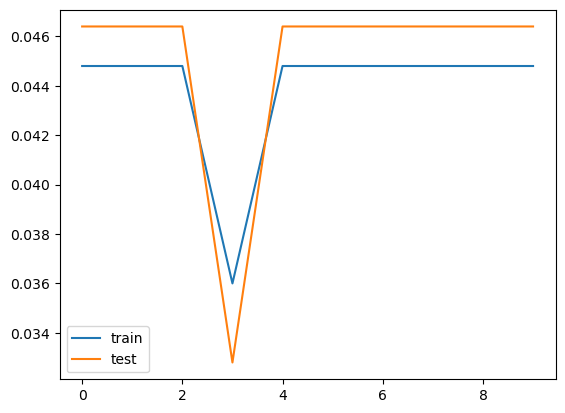

In [15]:
import sys
# 또는 상대 경로
sys.path.append('..') 

from util.plot import plot_acc


plot_acc(train_result, test_result)